# Задание 6: Дообучение предобученных моделей

In [11]:
import torch
import matplotlib.pyplot as plt
import utils
from torchvision import transforms, models
from torch.utils.data import DataLoader

In [ ]:
train_dataset = utils.CustomImageDataset(
    "data/train", transform=transforms.ToTensor(), target_size=(224, 224)
)
test_dataset = utils.CustomImageDataset(
    "data/test", transform=transforms.ToTensor(), target_size=(224, 224)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [21]:
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.get_class_names()))
model = model.to("cuda")

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

losses_train = []
accuracies_train = []

losses_test = []
accuracies_test = []

In [23]:
def run_epoch(validate: bool) -> tuple[float, float]:
    """Выполнение одной эпохи обучения или валидации модели.

    Args:
        validate (bool): Если True, выполняется валидация модели, иначе обучение.

    Returns:
        tuple[float, float]: Кортеж, содержащий среднюю потерю и точность модели на текущей эпохе.
    """
    if validate:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    correct = 0.0
    total = 0

    data_loader = test_loader if validate else train_loader

    for batch_x, batch_y in data_loader:
        inputs: torch.Tensor = batch_x.to("cuda")
        targets: torch.Tensor = batch_y.to("cuda")

        if not validate:
            optimizer.zero_grad()

        logits: torch.Tensor = model(inputs)
        loss: torch.Tensor = criterion(logits, targets)

        if not validate:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(dim=1, keepdim=True)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += targets.size(0)

    return total_loss / len(data_loader), correct / total

In [24]:
for epoch in range(15):
    train_loss, train_accuracy = run_epoch(False)
    test_loss, test_accuracy = run_epoch(True)

    losses_train.append(train_loss)
    accuracies_train.append(train_accuracy)
    losses_test.append(test_loss)
    accuracies_test.append(test_accuracy)

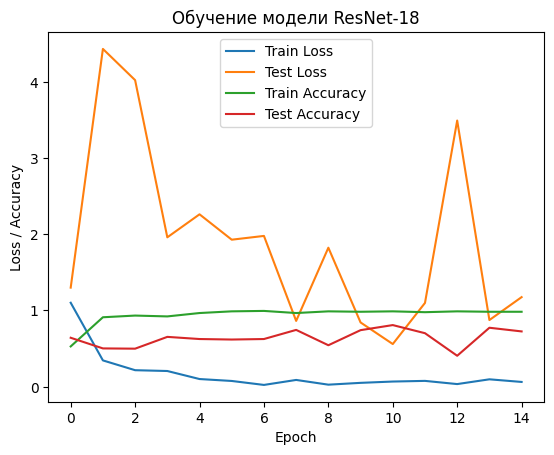

In [26]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.plot(accuracies_train, label="Train Accuracy")
plt.plot(accuracies_test, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.title("Обучение модели ResNet-18")
plt.show()